# 16S Analysis Challenge
[Prokaryotic 16S ribosomal RNA](https://en.wikipedia.org/wiki/16S_ribosomal_RNA) is often used for identifying bacterial species in microbiome research. Established bioinformatic pipelines such as QIIME2 can be used for analyzing this kind of data, but they can be difficult to install, optimize, and integrate into custom analysis pipelines.

The following workflow is an alternative to [QIIME2](https://docs.qiime2.org/2023.2/tutorials/) written in python. Here, I recapitulate the basic functions of QIIME2 such as

1) [Merging paired end reads](#merge_paired_end)
2) [Clustering reads with mmseq2](#clustering)
3) [Obtaining a feature matrix from sequencing data](#feature_matrix)
4) Applying taxon information
5) Performing multi-dimensional analysis.

The dataset used will be paired end reads from 16S sequencing from several soil microbiome samples.

`data/sample_sheet.csv` contains information about the sample_uuid, fwd_index_seq, and rev_index_seq. This information is used to demultiplex the reads and build the feature matrix.

`data/filtered/` contains paired end reads which will be merged, aligned, and demultiplex.   

In [1]:
# libraries to import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import subprocess
import glob

## Trimming and denoising
Before merging the paired end 16S reads, sequencing adapters must be trimmed. Low quality reads must also be removed. Otherwise, we will get many redundant clusters due to polymorphism from the sequencing primers.

`cutadapt` can be installed by running the following:
```
pip3 install cutadapt
```

In [110]:
def trim_adapters():
    # Collect files
    files = glob.glob('data/reads/*.fq*')
    files = [i.split('_')[0] for i in files]
    r1 = [i+'_1_filtered.fq.gz' for i in files]
    r2 = [i+'_2_filtered.fq.gz' for i in files]

    # make an output directory for merged reads
    cmd = 'mkdir trimmed'
    subprocess.run(cmd.split(' '))
    
    # merge the reads
    for i in range(len(files)):
        out1 = 'trimmed/'+r1[i].split('/')[-1]
        out2 = 'trimmed/'+r2[i].split('/')[-1]
        print('trimming',out1)

        # primers found in sample_sheet.csv
        fwd = 'GTGCCAGCMGCCGCGGTAA'
        rev = 'CCGTCAATTCMTTTRAGTTT'
        #rev = 'AAACTYAAAKGAATTGACGG'
        
        #cmd = 'cutadapt --quiet -g '+fwd+' -o '+fout+' '+f
        #subprocess.run(cmd.split(' '))
        #cmd = 'cutadapt --quiet -a '+rev+' -o '+fout+' '+f
        
        cmd = 'cutadapt --quiet -m 100 -g '+fwd+' -G '+rev+' -o '+out1+' -p '+out2+' '+r1[i]+' '+r2[i]
        subprocess.run(cmd.split(' '))


In [111]:
trim_adapters()

mkdir: cannot create directory ‘trimmed’: File exists


trimming trimmed/1c87f756-1e1e-4e5b-9d15-1e521ca9ead0_1_filtered.fq.gz
trimming trimmed/1b25234e-f4f0-4267-9ec4-1074413f2a92_1_filtered.fq.gz
trimming trimmed/1b25234e-f4f0-4267-9ec4-1074413f2a92_1_filtered.fq.gz
trimming trimmed/0c045daf-e31b-4609-9dc2-4b5acac6f34c_1_filtered.fq.gz
trimming trimmed/197a8e37-a390-4e21-b566-81d84701b2cd_1_filtered.fq.gz
trimming trimmed/0c045daf-e31b-4609-9dc2-4b5acac6f34c_1_filtered.fq.gz
trimming trimmed/149988af-0154-4c58-9625-777274345d99_1_filtered.fq.gz
trimming trimmed/15c12fd2-5c60-4868-b0d0-ff02a80301ed_1_filtered.fq.gz
trimming trimmed/084ec480-d86a-49a4-b408-5d595dc84757_1_filtered.fq.gz
trimming trimmed/0e407ce1-c5a0-4932-a5a9-fd0f77d1aa7c_1_filtered.fq.gz
trimming trimmed/0e407ce1-c5a0-4932-a5a9-fd0f77d1aa7c_1_filtered.fq.gz
trimming trimmed/16739e94-71af-4222-8e6c-8c800cd50a1e_1_filtered.fq.gz
trimming trimmed/1c7b8a61-087c-4c7d-8c9d-6755443db2b9_1_filtered.fq.gz
trimming trimmed/12e33dea-ea9e-4afc-a599-5adfb64be80e_1_filtered.fq.gz
trimmi

<a id='merge_paired_end'></a>
## Merging paired end reads
Paired end reads are merged by aligning the trimmed pairs of reads against each other. This is best done with dedicated tools like `ngmerge` which are precompiled work much faster than python code. Instructions for installing ngmerge can be [here](https://github.com/jsh58/NGmerge). Afterwards, we will copy ngmerge to the `bin/` directory and run the execute via `subprocess.call`.

The following lines will merge the reads.

In [112]:
def merge_reads():
    # Collect files
    files = glob.glob('trimmed/*.fq*')
    files = [i.split('_')[0] for i in files]

    # make an output directory for merged reads
    cmd = 'mkdir merged'
    subprocess.run(cmd.split(' '))
    
    # merge the reads
    for f in files:
        # define forward and reverse pairs
        r1 = f+'_1_filtered.fq.gz'
        r2 = f+'_2_filtered.fq.gz'
        fname = f.split('/')[-1]
        fout = 'merged/'+fname+'.fq.gz'
                
        # merge each pair of reads
        print('merging',f)
        cmd = './bin/NGmerge -1 '+r1+' -2 '+r2+' -o '+fout
        subprocess.run(cmd.split(' '))

In [113]:
merge_reads()

mkdir: cannot create directory ‘merged’: File exists


merging trimmed/1c87f756-1e1e-4e5b-9d15-1e521ca9ead0
merging trimmed/1c87f756-1e1e-4e5b-9d15-1e521ca9ead0
merging trimmed/1b25234e-f4f0-4267-9ec4-1074413f2a92
merging trimmed/1b25234e-f4f0-4267-9ec4-1074413f2a92
merging trimmed/0c045daf-e31b-4609-9dc2-4b5acac6f34c
merging trimmed/0c045daf-e31b-4609-9dc2-4b5acac6f34c
merging trimmed/197a8e37-a390-4e21-b566-81d84701b2cd
merging trimmed/197a8e37-a390-4e21-b566-81d84701b2cd
merging trimmed/149988af-0154-4c58-9625-777274345d99
merging trimmed/149988af-0154-4c58-9625-777274345d99
merging trimmed/15c12fd2-5c60-4868-b0d0-ff02a80301ed
merging trimmed/15c12fd2-5c60-4868-b0d0-ff02a80301ed
merging trimmed/084ec480-d86a-49a4-b408-5d595dc84757
merging trimmed/084ec480-d86a-49a4-b408-5d595dc84757
merging trimmed/0e407ce1-c5a0-4932-a5a9-fd0f77d1aa7c
merging trimmed/0e407ce1-c5a0-4932-a5a9-fd0f77d1aa7c
merging trimmed/16739e94-71af-4222-8e6c-8c800cd50a1e
merging trimmed/16739e94-71af-4222-8e6c-8c800cd50a1e
merging trimmed/1c7b8a61-087c-4c7d-8c9d-675544

<a id='clustering'></a>
## Clustering reads
To turn this into a feature vector, we need to cluster the reads. This can be done with `mmseqs2`, a useful tool for k-mer based clustering and sequence search. Installation instructions for `mmseqs2` can be found [here](https://github.com/soedinglab/MMseqs2).

If you are running ubuntu, `mmseqs2` can be easily installed by running the following command.

```
apt install mmseqs2
```

The following lines will use `mmsesq2` to obtain amplicon clusters, which we will later use to build a feature vector. `mmseq2` uses a `tmp/` directory to store temporary calculations. This can be deleted later. Clusters will be written to a folder with the header clusters.

In [134]:
def cluster_reads():
    # Cluster reads with linclust
    cmd = ['mkdir clusters']
    cmd+= ['mmseqs easy-linclust merged/*.fq.gz clusters/clst tmp']
    #cmd+= ['mmseqs easy-cluster merged/*.fq.gz clusters/clst tmp -c 0.95']
    # we only need clst_rep_seq.fasta
    # remove other files
    cmd+= ['mv clusters/clst_rep_seq.fasta data/clusters.fa']
    cmd+= ['rm clusters/*']
    for c in cmd:
        subprocess.call(c, shell=True)

In [135]:
cluster_reads()

mkdir: cannot create directory ‘clusters’: File exists


easy-linclust merged/054b5d2a-9215-4ebf-9b85-8721d91a6309.fq.gz merged/05fa3cf0-ba5c-4d79-a056-c79b99520322.fq.gz merged/0796b1c8-9989-4eee-8d3d-0438a6abb252.fq.gz merged/084ec480-d86a-49a4-b408-5d595dc84757.fq.gz merged/086df8bb-6c83-4884-9f14-32fea5d5a21b.fq.gz merged/08f7d4e4-9ed9-421b-9260-f0042e1a01ce.fq.gz merged/0c045daf-e31b-4609-9dc2-4b5acac6f34c.fq.gz merged/0cb3e599-0353-4652-942e-25f7f481c274.fq.gz merged/0e407ce1-c5a0-4932-a5a9-fd0f77d1aa7c.fq.gz merged/12e33dea-ea9e-4afc-a599-5adfb64be80e.fq.gz merged/149988af-0154-4c58-9625-777274345d99.fq.gz merged/15c12fd2-5c60-4868-b0d0-ff02a80301ed.fq.gz merged/166663ab-d4d7-4ce8-9edc-6ae17273cc73.fq.gz merged/16739e94-71af-4222-8e6c-8c800cd50a1e.fq.gz merged/197a8e37-a390-4e21-b566-81d84701b2cd.fq.gz merged/1b17c6b9-f6f9-4a23-be99-d13e9a8b9319.fq.gz merged/1b25234e-f4f0-4267-9ec4-1074413f2a92.fq.gz merged/1c667f2d-1bfc-495a-bf79-d4b9de736b3c.fq.gz merged/1c7b8a61-087c-4c7d-8c9d-6755443db2b9.fq.gz merged/1c87f756-1e1e-4e5b-9d15-1e521

<a id='feature_matrix'></a>
## Building the feature matrix 
The feature vector is obtained by aligning reads against the clusters and then obtaining counts of aligned sequences per sample. This can be done using fast aligners like `minimap2`. Installation instructions can be found [here](https://github.com/lh3/minimap2).

If you are running ubuntu, you can install `minimap2` by running the following commands.

```
apt install minimap2
```

The following functions will align merged reads for each sample against the center sequences of each cluster. The alignments are filtered to their best matches. A count matrix can then be generated from the resulting dataframe.

In [178]:
def parse_PAF(fname):
    '''
    This function parses the information from a PAF file and returns a dataframe
    fname = filename of paf file output from minimap2
    returns a dataframe
    '''
    with open(fname,'r') as f:
        text = f.read().split('\n')

    if len(text[-1])==0:
        text = text[:-1] # removes the last line that is empty    
    data = []

    # information we are parsing
    col1 = ['query_id','q_len','q_start','q_end','orientation',
            'database_id','t_len','t_start','t_end','match','tot','mapq']
    col2 = ['tp','cm','s1','s2','NM','AS','ms','nn','rl','cg']
    key = {col2[i]:i for i in range(0,len(col2))}
    for line in text:
        out = line.split('\t')
        # parses for other info
        info = [0]*len(key)
        for i in range(len(col1),len(out)):
            x = out[i].split(':')
            if x[0] in key:
                info[key[x[0]]] = x[-1]
        # save the data
        data.append(out[:len(col1)]+info)
    data = pd.DataFrame(data, columns=col1+col2)
    data = data.rename(columns={'cg':'CIGAR'})
    col = ['q_len','q_start','q_end','t_len','t_start','t_end','match','tot','NM','AS']
    for c in col:
        data[c] = data[c].astype(int)
    return data

def align_reads():
    '''
    This function aligns merged reads against the center sequences of each cluster using minimap2
    '''
    # run the alignment
    files = glob.glob('merged/*.fq*')
    files = [i.split('_')[0] for i in files]
    read1 = files
    
    # define results folder
    ofile = 'tmp/results.paf'
    df = []
    for i in range(len(read1)):
        print('aligning',read1[i], i, len(read1))
        c = 'minimap2 -c -x map-ont data/cluster_lin.fa '+read1[i]+' -o '+ofile
        subprocess.call(c, shell=True)
        x = parse_PAF(ofile)
        x['sample'] = read1[i].split('/')[-1].split('.')[0]
        
        # compute similarity score
        x['match_score'] = x['match']/x['tot']
        L = [min(i,j) for i,j in x[['q_len','t_len']].values]
        x['similarity'] = x['match']/L
        
        # sort to best match
        x = get_best(x,'query_id')
        df.append(x)
    df = pd.concat(df)
    return df

def get_best(df, col, metric='match_score', stat='idxmax'):
    '''
    This function assigns each query to its best match
    '''
    df=df.reset_index(drop=True)
    idx = df.groupby(by=col).agg({metric:stat}).reset_index()
    return df.iloc[idx[metric].values].reset_index()    

In [179]:
df = align_reads()
# save alignment information
df.to_csv('data/alignments.csv.gz', index=False)

aligning merged/1c87f756-1e1e-4e5b-9d15-1e521ca9ead0.fq.gz 0 20
aligning merged/1b25234e-f4f0-4267-9ec4-1074413f2a92.fq.gz 1 20


[M::mm_idx_gen::0.031*1.04] collected minimizers
[M::mm_idx_gen::0.040*1.43] sorted minimizers
[M::main::0.040*1.43] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.041*1.41] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.042*1.40] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::0.103*2.31] mapped 137 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/1c87f756-1e1e-4e5b-9d15-1e521ca9ead0.fq.gz
[M::main] Real time: 0.105 sec; CPU: 0.240 sec; Peak RSS: 8.161 GB
[M::mm_idx_gen::0.031*1.04] collected minimizers
[M::mm_idx_gen::0.039*1.43] sorted minimizers
[M::main::0.039*1.43] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.041*1.42] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_

aligning merged/0c045daf-e31b-4609-9dc2-4b5acac6f34c.fq.gz 2 20
aligning merged/197a8e37-a390-4e21-b566-81d84701b2cd.fq.gz 3 20


[M::worker_pipeline::7.943*2.97] mapped 18168 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/197a8e37-a390-4e21-b566-81d84701b2cd.fq.gz
[M::main] Real time: 7.962 sec; CPU: 23.607 sec; Peak RSS: 8.161 GB


aligning merged/149988af-0154-4c58-9625-777274345d99.fq.gz 4 20


[M::mm_idx_gen::0.035*1.03] collected minimizers
[M::mm_idx_gen::0.043*1.39] sorted minimizers
[M::main::0.043*1.39] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.045*1.38] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.046*1.37] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::44.385*2.98] mapped 91386 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/149988af-0154-4c58-9625-777274345d99.fq.gz
[M::main] Real time: 44.433 sec; CPU: 132.187 sec; Peak RSS: 8.161 GB


aligning merged/15c12fd2-5c60-4868-b0d0-ff02a80301ed.fq.gz 5 20


[M::mm_idx_gen::0.037*1.04] collected minimizers
[M::mm_idx_gen::0.045*1.38] sorted minimizers
[M::main::0.045*1.38] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.047*1.37] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.048*1.36] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::19.049*2.98] mapped 40173 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/15c12fd2-5c60-4868-b0d0-ff02a80301ed.fq.gz
[M::main] Real time: 19.083 sec; CPU: 56.750 sec; Peak RSS: 8.177 GB


aligning merged/084ec480-d86a-49a4-b408-5d595dc84757.fq.gz 6 20
aligning merged/0e407ce1-c5a0-4932-a5a9-fd0f77d1aa7c.fq.gz 7 20


[M::mm_idx_gen::0.034*1.04] collected minimizers
[M::mm_idx_gen::0.042*1.40] sorted minimizers
[M::main::0.042*1.40] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.043*1.39] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.044*1.38] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::0.089*2.16] mapped 100 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/084ec480-d86a-49a4-b408-5d595dc84757.fq.gz
[M::main] Real time: 0.092 sec; CPU: 0.195 sec; Peak RSS: 8.177 GB
[M::mm_idx_gen::0.032*1.04] collected minimizers
[M::mm_idx_gen::0.040*1.42] sorted minimizers
[M::main::0.040*1.42] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.041*1.41] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_

aligning merged/16739e94-71af-4222-8e6c-8c800cd50a1e.fq.gz 8 20


[M::mm_idx_gen::0.034*1.04] collected minimizers
[M::mm_idx_gen::0.042*1.40] sorted minimizers
[M::main::0.042*1.40] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.044*1.39] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.045*1.38] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::34.538*2.98] mapped 74806 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/16739e94-71af-4222-8e6c-8c800cd50a1e.fq.gz
[M::main] Real time: 34.597 sec; CPU: 102.864 sec; Peak RSS: 8.177 GB


aligning merged/1c7b8a61-087c-4c7d-8c9d-6755443db2b9.fq.gz 9 20


[M::mm_idx_gen::0.036*1.04] collected minimizers
[M::mm_idx_gen::0.044*1.39] sorted minimizers
[M::main::0.044*1.39] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.045*1.37] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.046*1.36] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::36.740*2.98] mapped 72164 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/1c7b8a61-087c-4c7d-8c9d-6755443db2b9.fq.gz
[M::main] Real time: 36.811 sec; CPU: 109.608 sec; Peak RSS: 8.177 GB


aligning merged/12e33dea-ea9e-4afc-a599-5adfb64be80e.fq.gz 10 20


[M::mm_idx_gen::0.035*1.04] collected minimizers
[M::mm_idx_gen::0.043*1.39] sorted minimizers
[M::main::0.043*1.39] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.045*1.38] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.046*1.37] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::16.758*2.97] mapped 37054 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/12e33dea-ea9e-4afc-a599-5adfb64be80e.fq.gz
[M::main] Real time: 16.790 sec; CPU: 49.866 sec; Peak RSS: 8.177 GB


aligning merged/166663ab-d4d7-4ce8-9edc-6ae17273cc73.fq.gz 11 20


[M::mm_idx_gen::0.034*1.04] collected minimizers
[M::mm_idx_gen::0.042*1.40] sorted minimizers
[M::main::0.042*1.40] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.043*1.38] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.045*1.37] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::27.157*2.98] mapped 55372 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/166663ab-d4d7-4ce8-9edc-6ae17273cc73.fq.gz
[M::main] Real time: 27.203 sec; CPU: 80.942 sec; Peak RSS: 8.177 GB


aligning merged/08f7d4e4-9ed9-421b-9260-f0042e1a01ce.fq.gz 12 20


[M::mm_idx_gen::0.034*1.04] collected minimizers
[M::mm_idx_gen::0.043*1.40] sorted minimizers
[M::main::0.043*1.40] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.044*1.38] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.045*1.37] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::82.044*2.98] mapped 176115 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/08f7d4e4-9ed9-421b-9260-f0042e1a01ce.fq.gz
[M::main] Real time: 82.149 sec; CPU: 244.368 sec; Peak RSS: 8.177 GB


aligning merged/0cb3e599-0353-4652-942e-25f7f481c274.fq.gz 13 20


[M::mm_idx_gen::0.041*1.03] collected minimizers
[M::mm_idx_gen::0.049*1.35] sorted minimizers
[M::main::0.049*1.35] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.051*1.34] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.052*1.33] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::24.566*2.98] mapped 50514 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/0cb3e599-0353-4652-942e-25f7f481c274.fq.gz
[M::main] Real time: 24.611 sec; CPU: 73.190 sec; Peak RSS: 8.670 GB


aligning merged/05fa3cf0-ba5c-4d79-a056-c79b99520322.fq.gz 14 20


[M::mm_idx_gen::0.034*1.04] collected minimizers
[M::mm_idx_gen::0.043*1.40] sorted minimizers
[M::main::0.043*1.40] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.044*1.39] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.045*1.38] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::30.295*2.98] mapped 65111 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/05fa3cf0-ba5c-4d79-a056-c79b99520322.fq.gz
[M::main] Real time: 30.343 sec; CPU: 90.212 sec; Peak RSS: 8.670 GB


aligning merged/1b17c6b9-f6f9-4a23-be99-d13e9a8b9319.fq.gz 15 20


[M::mm_idx_gen::0.035*1.04] collected minimizers
[M::mm_idx_gen::0.043*1.39] sorted minimizers
[M::main::0.043*1.39] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.044*1.38] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.045*1.37] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::27.770*2.98] mapped 55069 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/1b17c6b9-f6f9-4a23-be99-d13e9a8b9319.fq.gz
[M::main] Real time: 27.814 sec; CPU: 82.751 sec; Peak RSS: 8.670 GB


aligning merged/086df8bb-6c83-4884-9f14-32fea5d5a21b.fq.gz 16 20


[M::mm_idx_gen::0.034*1.04] collected minimizers
[M::mm_idx_gen::0.043*1.40] sorted minimizers
[M::main::0.043*1.40] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.044*1.38] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.045*1.37] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::43.451*2.98] mapped 84988 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/086df8bb-6c83-4884-9f14-32fea5d5a21b.fq.gz
[M::main] Real time: 43.513 sec; CPU: 129.558 sec; Peak RSS: 8.670 GB


aligning merged/054b5d2a-9215-4ebf-9b85-8721d91a6309.fq.gz 17 20


[M::mm_idx_gen::0.036*1.04] collected minimizers
[M::mm_idx_gen::0.044*1.39] sorted minimizers
[M::main::0.044*1.39] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.046*1.37] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.047*1.36] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::39.761*2.98] mapped 82079 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/054b5d2a-9215-4ebf-9b85-8721d91a6309.fq.gz
[M::main] Real time: 39.831 sec; CPU: 118.471 sec; Peak RSS: 8.670 GB


aligning merged/1c667f2d-1bfc-495a-bf79-d4b9de736b3c.fq.gz 18 20
aligning merged/0796b1c8-9989-4eee-8d3d-0438a6abb252.fq.gz 19 20


[M::mm_idx_gen::0.036*1.03] collected minimizers
[M::mm_idx_gen::0.044*1.38] sorted minimizers
[M::main::0.044*1.38] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.046*1.37] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_idx_stat::0.047*1.36] distinct minimizers: 87261 (75.81% are singletons); average occurrences: 3.239; average spacing: 5.724; total length: 1618099
[M::worker_pipeline::0.127*2.36] mapped 192 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -c -x map-ont -o tmp/results.paf data/cluster_lin.fa merged/1c667f2d-1bfc-495a-bf79-d4b9de736b3c.fq.gz
[M::main] Real time: 0.129 sec; CPU: 0.301 sec; Peak RSS: 8.670 GB
[M::mm_idx_gen::0.032*1.04] collected minimizers
[M::mm_idx_gen::0.040*1.42] sorted minimizers
[M::main::0.040*1.42] loaded/built the index for 4327 target sequence(s)
[M::mm_mapopt_update::0.041*1.41] mid_occ = 763
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 4327
[M::mm_

In [182]:
df = pd.read_csv('data/alignments.csv.gz')
col = ['sample','query_id','database_id','q_start','q_end','q_len','t_start','t_end','t_len','match_score']
df.sort_values(by=['sample','database_id'])[col]

,sample,query_id,database_id,q_start,q_end,q_len,t_start,t_end,t_len,match_score
891167,054b5d2a-9215-4ebf-9b85-8721d91a6309,M03990:240:000000000-CY8DT:1:1102:9936:8884,0,0,371,371,0,370,370,0.935310
901441,054b5d2a-9215-4ebf-9b85-8721d91a6309,M03990:240:000000000-CY8DT:1:1115:21897:12517,0,0,372,372,0,370,370,0.922043
911987,054b5d2a-9215-4ebf-9b85-8721d91a6309,M03990:240:000000000-CY8DT:1:2109:9785:4144,0,0,371,371,0,370,370,0.938005
941849,054b5d2a-9215-4ebf-9b85-8721d91a6309,M03990:241:000000000-CYLNG:1:1117:18396:19054,0,0,370,370,0,370,370,0.948649
968329,054b5d2a-9215-4ebf-9b85-8721d91a6309,M03990:241:000000000-CYLNG:1:2117:26691:13438,4,0,376,376,0,376,376,0.952128
...,...,...,...,...,...,...,...,...,...,...
58,1c87f756-1e1e-4e5b-9d15-1e521ca9ead0,M03990:241:000000000-CYLNG:1:1108:8948:20103,4211,0,374,374,0,372,372,0.933511
116,1c87f756-1e1e-4e5b-9d15-1e521ca9ead0,M03990:241:000000000-CYLNG:1:2113:22454:14301,4220,0,289,373,0,289,373,0.989619
23,1c87f756-1e1e-4e5b-9d15-1e521ca9ead0,M03990:240:000000000-CY8DT:1:2101:8493:10084,4243,0,371,374,0,371,398,0.951482
18,1c87f756-1e1e-4e5b-9d15-1e521ca9ead0,M03990:240:000000000-CY8DT:1:1116:25526:10295,4285,0,374,374,0,374,374,0.935829


### Visualizing alignments quality
Plotting a histogram of `match_score` for all merged reads indicate most reads match the cluster center sequences at more than 90% match. This means we should be able to build a decent feature matrix off these alignments.

Plotting a histogram of `similarity` indicate some reads match closely to the reference, but they match only at certain subsequences.

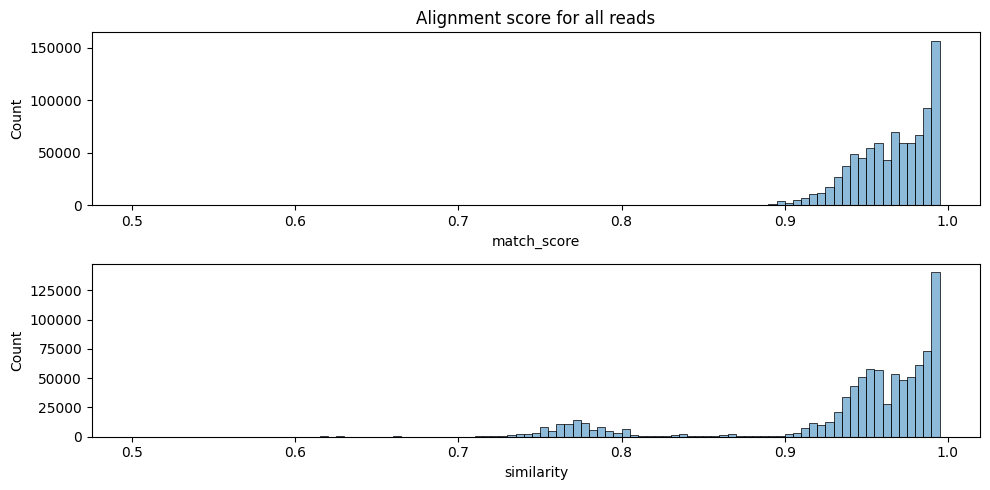

In [206]:
plt.figure(1, figsize=(10,5))
plt.subplot(2,1,1)
sns.histplot(data=df, x='match_score',bins=np.arange(0.5,1,0.005), alpha=0.5)
plt.title('Alignment score for all reads')

plt.subplot(2,1,2)
sns.histplot(data=df, x='similarity',bins=np.arange(0.5,1,0.005), alpha=0.5)
plt.tight_layout()
plt.show()

In [208]:
x = df[df['similarity'] < 0.85]
x['database_id'].drop_duplicates()
col = ['database_id','q_start','q_end','q_len','t_start','t_end','t_len','CIGAR','match_score','similarity']
x.sort_values(by='database_id')[col]

,database_id,q_start,q_end,q_len,t_start,t_end,t_len,CIGAR,match_score,similarity
14590,23,0,306,374,0,306,374,306M,0.980392,0.802139
513319,23,0,306,374,0,306,374,306M,0.980392,0.802139
961050,23,0,306,374,0,306,374,306M,0.993464,0.812834
587210,23,0,306,374,0,306,374,306M,0.977124,0.799465
520646,23,0,306,374,0,306,374,306M,0.980392,0.802139
...,...,...,...,...,...,...,...,...,...,...
566406,4315,0,288,374,0,288,372,288M,0.961806,0.744624
516313,4315,0,288,374,0,288,372,288M,0.958333,0.741935
225681,4315,0,288,374,0,288,372,288M,0.958333,0.741935
385974,4315,6,288,374,6,288,372,282M,0.957447,0.725806


A subset of reads are poorly aligned. This could indicate issues with read trimming, contamination, or missing cluster sequences. We could try to recluster these subsets of poorly aligned reads and see if adding these sequences to the set would help.

A violinplot of the read `similarity` vs samples show most reads are correctly aligned to the reference sequences for all samples. Though it is not perfect, this maybe good enough to build a feature matrix for classification.

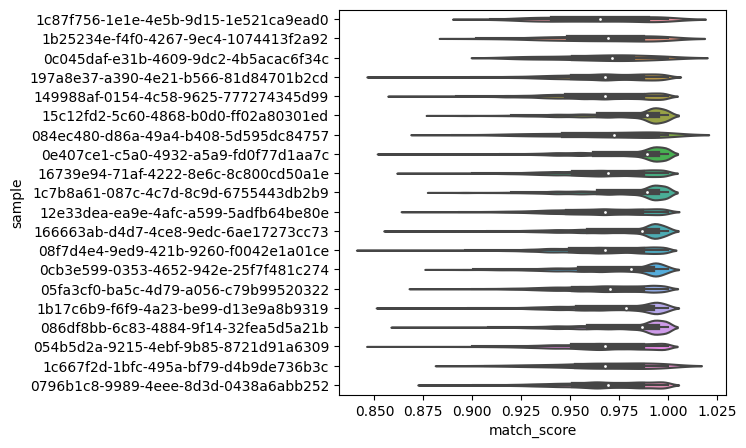

In [237]:
plt.figure(2, figsize=(5,5))
sns.violinplot(data=df, x='match_score', y='sample')
plt.show()

### Generating the feature matrix
The function below will transform the alignment information into a feature matrix. The features will be sorted from left to right by relative abundance and normalized to the total counts within the sample.

In [347]:
def get_feature_matrix(df):
    # get counts for each sample and feature
    col = ['sample','database_id','count']
    df['count'] = 1
    x = df[col].groupby(['sample','database_id']).sum().reset_index()
    # sort features by most frequently occuring samples
    y = x[col].groupby(['database_id']).sum().reset_index()
    y = y.sort_values(by='count')
    db = y.iloc[::-1]['database_id'].values
    jdict = {db[i]:i for i in range(len(db))}    
    # populate the indices for sample
    sample = x['sample'].drop_duplicates().values
    # initialize the feature matrix
    L = len(sample)
    N = len(db)
    mat = np.zeros([L,N])
    for i in range(len(sample)):
        x1 = x[x['sample']==sample[i]]
        for j,k in x1[['database_id','count']].values:
            j = jdict[j]
            mat[i,j] = k
        # normalize counts by total counts
        mat[i,:] = mat[i,:]/np.sum(mat[i,:])
    mat = pd.DataFrame(mat, columns=db)
    mat['sample'] = sample
    col = ['sample']+[i for i in db]
    mat = mat[col]
    return mat

In [348]:
mat = get_feature_matrix(df)

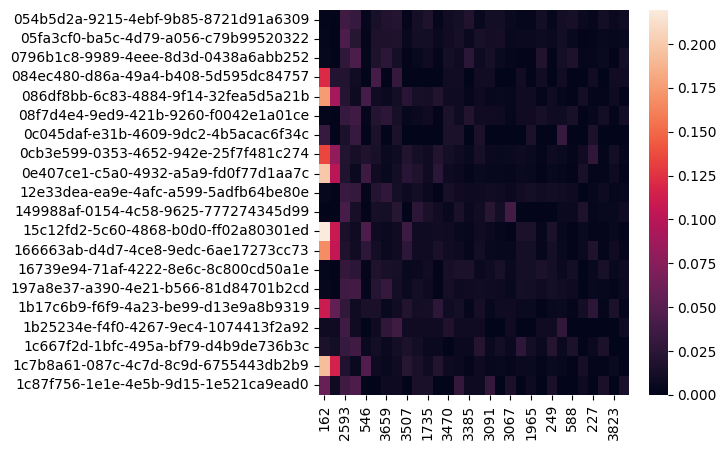

In [349]:
plt.figure(1, figsize=(5,5))
# display only first 30 columns
ylabel = mat['sample']
sns.heatmap(data=mat[mat.columns[1:31]], yticklabels=ylabel)
plt.show()

## Clustering the samples and features

The heatmap above indicates certain samples can be clustered together. We can visualize some of these samples with a clustermap. 

<Figure size 500x300 with 0 Axes>

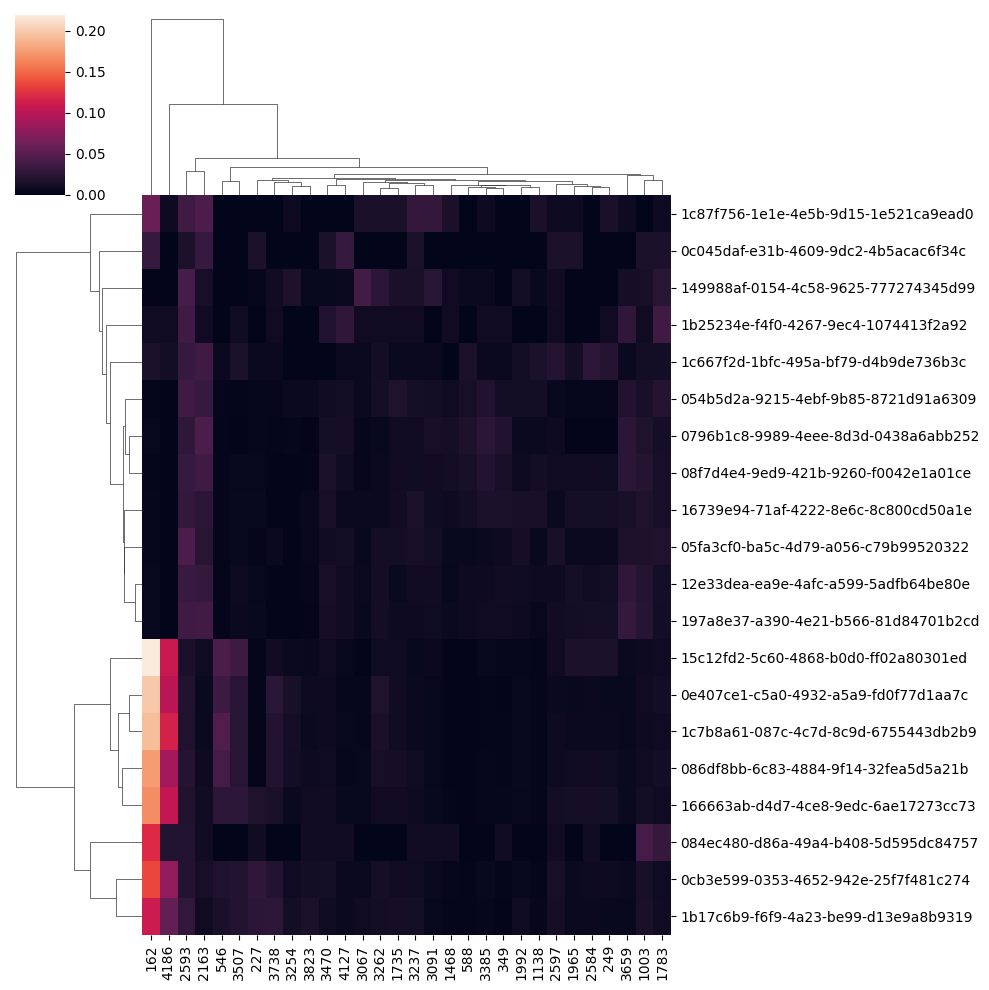

In [346]:
plt.figure(1, figsize=(5,3))
# display only first 30 columns
ylabel = mat['sample']
sns.clustermap(data=mat[mat.columns[1:31]], yticklabels=ylabel)
plt.show()

The cluster map shows that samples can be clustered into roughly three major groups based on relative abundance information. The species themselves on the x-axis can also be clustered together. We can apply taxonomy to some of these species to understand what they might mean.